In [2]:
import tclab
import gymnasium as gym

In [60]:
import random
# genertor nastaw temperatury
def setpoint_gen(clk):
    lower_constraint = 200  # minimalny okres zmian nastaw temperatury [s]
    upper_constraint = 600  # maksymalny okres zmian nastaw temperatury [s]

    last_change = 0                         # czas ostatniej zmiany nastawy
    T_sp = random.randint(30, 70)           # wartość następnej nastawy temperatury
    next_change = random.randint(lower_constraint, upper_constraint)  # czas następnej zmiany temperatury

    while True:
        yield T_sp

        time = next(clk)
        if last_change + next_change <= time:
            T_sp = random.randint(30, 70)
            next_change = random.randint(lower_constraint, upper_constraint)
            last_change = time
        
    

In [110]:
class SystemState():
    def __init__(self):
        # nastawiona wartość temperatury
        self.T_sp = 0
        # aktualna wartość temperatury
        self.T = 0

class Environment(gym.Env):
    SPEEDUP = 100
    EPISODE_TIME = 90 * 60 #[s]
    C_COEF = 1
    E_COEF = 0
    COMFORT_CONSTR = 1 #[*C]  dopuszczalne odstępstwa od nastawionej wartości

    def __init__(self):
        # parametry symulacji
        self.TCLab = tclab.setup(connected=False, speedup=self.SPEEDUP)

        # Inicjalizacja cyfrowego bliźniaka
        self.lab = tclab.TCLabModel() 
        self.clk = tclab.clock(self.EPISODE_TIME+2)
        
        # inicjalizacja generatora nastaw
        self._T_gen = setpoint_gen(self.clk)

        # inicjalizacja stanu początkowego
        self.state = SystemState()
        self.__state_update()




    def reset(self):
        self.clk = tclab.clock(self.EPISODE_TIME+2)
        self._T_gen = setpoint_gen(self.clk)
        return self.state

    def step(self, action):
        time = next(self.clk)
        self.__set_control(action)
        self.__state_update()
        reward = self.__calculate_reward(action)
        done = time >= self.EPISODE_TIME 
        info = 0

        return self.state, reward, done, info
    
    def __calculate_reward(self, action):
        comfort = 1 if abs(self.state.T - self.state.T_sp) <= self.COMFORT_CONSTR else 0
        energy = action / 100
        return comfort * self.C_COEF + energy * self.E_COEF

    def __state_update(self):
        self.state.T_sp = next(self._T_gen)
        self.state.T = self.lab.T1

    def __set_control(self, action):
        self.lab.Q1(max(min(100, action), 0))



In [98]:
# Przyjęte parametry regulatora pid 
Kc   = 6.0
tauI = 75.0 # sec
tauD = 0.0  # sec


def PID(y, sp, dt, eps_int, prev_y):
    eps = sp - y

    eps_int += eps
    eps_dt = (y - prev_y) / dt if dt>0 else 0

    control = Kc * (eps + eps_int/tauI + tauD*eps_dt) 
    return float(control), eps_int

In [111]:
import numpy as np
n = 1000
T, T_sp, reward, times, controls = np.zeros(n), np.zeros( n), np.zeros(n), np.zeros(n), np.zeros(n)
env = Environment()
state = env.reset() 

eps_int, prev_y = 0, 0
prev_time = 0

for i in range(n):
    times[i] = next(env.clk)
    dt = times[i] - prev_time 
    prev_time = times[i]

    control, eps_int = PID(env.state.T, env.state.T_sp, dt, eps_int, prev_y)
    state, reward[i], done, info = env.step(control)
    T[i], T_sp[i] = state.T, state.T_sp
    controls[i] = control



TCLab version 1.0.0
Simulated TCLab


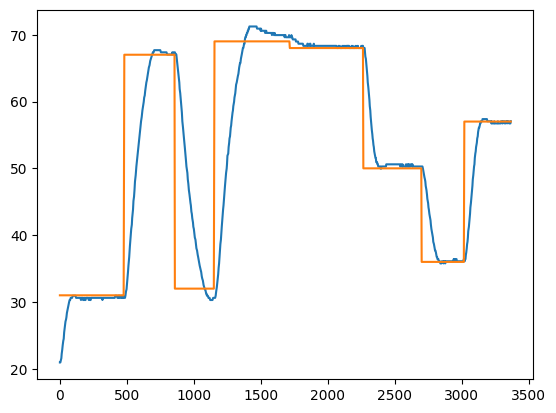

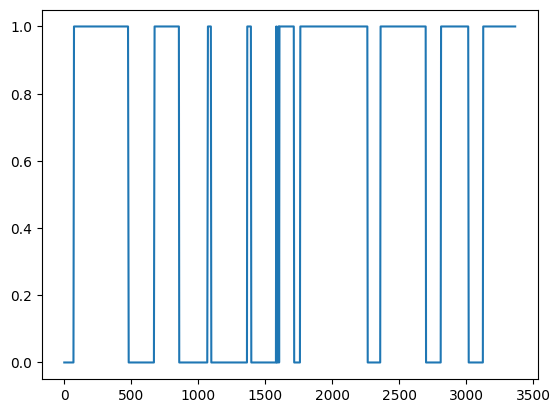

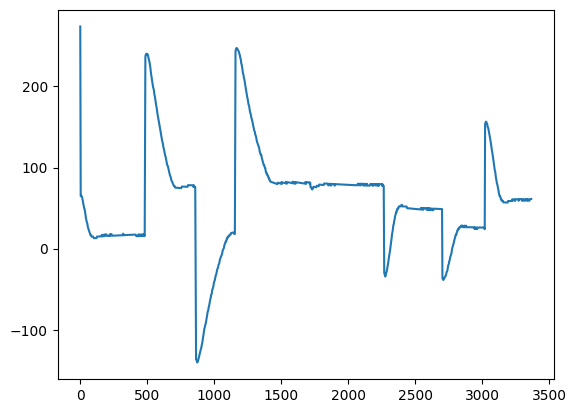

In [112]:
import matplotlib.pyplot as plt

plt.plot(times, T)
plt.plot(times, T_sp)
plt.show()
plt.plot(times, reward)
plt.show()
plt.plot(times, controls)
plt.show()